In [1]:
import sys, os, time
import logging
import torch
import pickle
import numpy as np
import cv2
from pathlib import Path

sys.path.insert(0, '/home/rajeev-gupta/sensyn_ws/src/GD-MAE')


In [2]:
from pcdet.models.detectors import GraphRCNN
from pcdet.config import cfg, cfg_from_yaml_file
from pcdet.datasets.nuscenes.nuscenes_dataset import NuScenesDataset
from pcdet.datasets import build_dataloader


In [3]:
log_path = './test_logs.txt'
cfg_file = '/home/rajeev-gupta/sensyn_ws/src/GD-MAE/tools/cfgs/kitti_models/graph_rcnn_voi_nuscenes.yaml'
ckpt_path = '/home/rajeev-gupta/sensyn_ws/src/GD-MAE/data/ckpts/graph_rcnn_voi_kitti.pth'
to_cpu = False
batch_size = 1
dist_test = False
workers = 4
root_path = Path('/media/rajeev-gupta/Drive250/SENSYN_/CMT')

In [4]:
#Logger
def create_logger(log_file=None, rank=0, log_level=logging.INFO):
    logger = logging.getLogger(__name__)
    logger.setLevel(log_level if rank == 0 else 'ERROR')
    formatter = logging.Formatter('%(asctime)s  %(levelname)5s  %(message)s')
    console = logging.StreamHandler()
    console.setLevel(log_level if rank == 0 else 'ERROR')
    console.setFormatter(formatter)
    logger.addHandler(console)
    if log_file is not None:
        file_handler = logging.FileHandler(filename=log_file)
        file_handler.setLevel(log_level if rank == 0 else 'ERROR')
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)
    logger.propagate = False
    return logger

In [5]:
def load_data_to_gpu(batch_dict):
    for key, val in batch_dict.items():
        if not isinstance(val, np.ndarray):
            continue
        elif key in ['frame_id', 'metadata', 'calib', 'image_shape', 'image_pad_shape', 'image_rescale_shape']:
            continue
        else:
            batch_dict[key] = torch.from_numpy(val).float().cuda()


In [6]:
logger = create_logger(log_path)

In [7]:
cfg_from_yaml_file(cfg_file, cfg)

{'ROOT_DIR': PosixPath('/home/rajeev-gupta/sensyn_ws/src/GD-MAE'),
 'LOCAL_RANK': 0,
 'CLASS_NAMES': ['Car'],
 'DATA_CONFIG': {'DATASET': 'NuScenesDataset',
  'DATA_PATH': '../data/nuscenes',
  'VERSION': 'v1.0-mini',
  'MAX_SWEEPS': 10,
  'PRED_VELOCITY': True,
  'SET_NAN_VELOCITY_TO_ZEROS': True,
  'FILTER_MIN_POINTS_IN_GT': 1,
  'BACKEND': {'NAME': 'HardDiskBackend'},
  'DATA_SPLIT': {'train': 'train', 'test': 'val'},
  'INFO_PATH': {'train': ['nuscenes_infos_train.pkl'],
   'test': ['nuscenes_infos_val.pkl']},
  'POINT_CLOUD_RANGE': [-51.2, -51.2, -5.0, 51.2, 51.2, 3.0],
  'BALANCED_RESAMPLING': True,
  'DATA_AUGMENTOR': {'DISABLE_AUG_LIST': ['placeholder'],
   'AUG_CONFIG_LIST': [{'NAME': 'random_world_flip',
     'PROBABILITY': 0.5,
     'ALONG_AXIS_LIST': ['x']},
    {'NAME': 'random_world_rotation',
     'PROBABILITY': 1.0,
     'WORLD_ROT_ANGLE': [-0.78539816, 0.78539816]},
    {'NAME': 'random_world_scaling',
     'PROBABILITY': 1.0,
     'WORLD_SCALE_RANGE': [0.95, 1.05]}]},

In [8]:
dataset = NuScenesDataset(
        dataset_cfg=cfg.DATA_CONFIG,
        class_names=cfg.CLASS_NAMES,
        root_path=root_path,
        training=False,
        logger=logger,
    )

2024-07-08 23:41:26,692   INFO  Loading NuScenes dataset
2024-07-08 23:41:26,789   INFO  Total samples for NuScenes dataset: 81


In [9]:
dataset.infos

[{'lidar_path': '/media/rajeev-gupta/Drive250/SENSYN_/CMT/data/nuscenes/samples/LIDAR_TOP/n008-2018-08-01-15-16-36-0400__LIDAR_TOP__1533151603547590.pcd.bin',
  'token': '3e8750f331d7499e9b5123e9eb70f2e2',
  'sweeps': [],
  'cams': {'CAM_FRONT': {'data_path': 'data/nuscenes/samples/CAM_FRONT/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151603512404.jpg',
    'type': 'CAM_FRONT',
    'sample_data_token': '4f5e35aa6c6a426ca945e206fb2f4921',
    'sensor2ego_translation': [1.72200568478, 0.00475453292289, 1.49491291905],
    'sensor2ego_rotation': [0.5077241387638071,
     -0.4973392230703816,
     0.49837167536166627,
     -0.4964832014373754],
    'ego2global_translation': [599.849775495386, 1647.6411294309523, 0.0],
    'ego2global_rotation': [-0.9687876119182126,
     -0.004506968075376869,
     -0.00792272203393983,
     0.24772460658591755],
    'timestamp': 1533151603512404,
    'sensor2lidar_rotation': array([[ 0.99988013, -0.01013819, -0.0117025 ],
           [ 0.01223258,  0.053

In [10]:
test_set, test_loader, sampler = build_dataloader(
        dataset_cfg=cfg.DATA_CONFIG,
        class_names=cfg.CLASS_NAMES,
        batch_size=batch_size,
        dist=dist_test, workers=workers, logger=logger, training=False
    )

2024-07-08 23:41:28,555   INFO  Loading NuScenes dataset
2024-07-08 23:41:28,556   INFO  Total samples for NuScenes dataset: 0


In [11]:
for i, batch in enumerate(test_loader):
    print(batch)
    break


In [12]:
get_dict = dataset.__getitem__(4)
get_dict

{'P2': array([[ 1.25281310e+03,  0.00000000e+00,  8.26588115e+02,
         1.26658414e-03],
       [ 0.00000000e+00,  1.25281310e+03,  4.69984663e+02,
        -3.60236865e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        -4.27213188e-01]]), 'R0': array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), 'Tr_velo2cam': array([[ 0.99987894,  0.01345945, -0.0078075 ,  0.00126658],
       [-0.00855879,  0.05669609, -0.9983548 , -0.36023686],
       [-0.01299465,  0.99830075,  0.05680442, -0.42721319]])}


{'points': array([[-16.499926 ,  24.63673  ,   2.8052444,  23.       ],
        [-16.462418 ,  24.596064 ,   3.5070446,  24.       ],
        [-16.40202  ,  24.520752 ,   4.198981 ,  28.       ],
        ...,
        [ 14.236977 ,  24.076305 ,   4.0033116,  12.       ],
        [ 14.644968 ,  24.753658 ,   4.8055277,  14.       ],
        [ 14.623489 ,  24.69679  ,   5.494057 ,  15.       ]],
       dtype=float32),
 'frame_id': 'n008-2018-08-01-15-16-36-0400__LIDAR_TOP__1533151605548192.pcd',
 'metadata': {'token': '747aa46b9a4641fe90db05d97db2acea'},
 'image': array([[[-0.19400874, -0.31906286, -0.25640026],
         [-0.2245516 , -0.35122788, -0.28810084],
         [-0.2245516 , -0.35122788, -0.28810084],
         ...,
         [-0.65846735, -0.8368054 , -0.99228895],
         [-0.66695887, -0.84574795, -1.0011023 ],
         [-0.6742828 , -0.85346085, -1.0087038 ]],
 
        [[-0.19185932, -0.31679928, -0.25416937],
         [-0.20364128, -0.329207  , -0.26639792],
         [-0.203

In [13]:
img = get_dict['image']
img.shape

(384, 1280, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


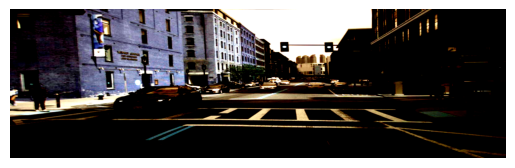

In [14]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [15]:
get_dict['points'].shape

(2937, 4)

In [16]:
get_dict['points'][78]

array([-16.078468,  26.254475,   0.737218,   4.      ], dtype=float32)

In [17]:
for key, val in get_dict.items():
    print(key)
    if type(val) == tuple:
        get_dict[key] = list(val)
    elif key == 'points':
        # add a zero column
        n = val.shape[0]
        z_col = np.zeros((n, 1), dtype=float)
        get_dict[key] = np.concatenate((z_col, val), axis = 1)
        continue
    elif key == 'image':
        # transpose (384, 1280, 3) to (3, 384, 1280)
        val_transposed = np.transpose(val, (2, 0, 1))
        get_dict[key] = val_transposed
        # print(get_dict[key].shape)
    elif key == 'transformation_2d_list' or key == 'transformation_2d_params':
        get_dict[key] = [val]
        continue
    get_dict[key] = np.array([get_dict[key]])
            
get_dict['batch_size'] = 1
get_dict['points'][:, 4] = 1

points
frame_id
metadata
image
trans_lidar_to_cam
trans_cam_to_img
gt_boxes
use_lead_xyz
transformation_2d_list
transformation_2d_params
image_rescale_shape
image_pad_shape
image_shape


In [18]:
get_dict

{'points': array([[  0.        , -16.49992561,  24.63673019,   2.80524445,
           1.        ],
        [  0.        , -16.4624176 ,  24.59606361,   3.50704455,
           1.        ],
        [  0.        , -16.4020195 ,  24.52075195,   4.19898081,
           1.        ],
        ...,
        [  0.        ,  14.23697662,  24.07630539,   4.00331163,
           1.        ],
        [  0.        ,  14.64496803,  24.75365829,   4.80552769,
           1.        ],
        [  0.        ,  14.62348938,  24.6967907 ,   5.49405718,
           1.        ]]),
 'frame_id': array(['n008-2018-08-01-15-16-36-0400__LIDAR_TOP__1533151605548192.pcd'],
       dtype='<U62'),
 'metadata': array([{'token': '747aa46b9a4641fe90db05d97db2acea'}], dtype=object),
 'image': array([[[[-0.19400874, -0.2245516 , -0.2245516 , ..., -0.65846735,
           -0.66695887, -0.6742828 ],
          [-0.19185932, -0.20364128, -0.20377396, ..., -0.66082907,
           -0.6354872 , -0.6134889 ],
          [-0.19528246, -0.1

In [19]:
get_dict['image'].shape

(1, 3, 384, 1280)

In [20]:
get_dict['points'].shape

(2937, 5)

In [21]:
model = GraphRCNN(cfg.MODEL, num_class=len(cfg.CLASS_NAMES), dataset=dataset, logger=logger)

/media/rajeev-gupta/Drive250/conda_envs/new_graphrcnn/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180589158/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2024-07-08 23:41:33,349   INFO  DLASeg is freezed
2024-07-08 23:41:33,350   INFO  DynVFE is freezed
2024-07-08 23:41:33,352   INFO  VoxelBackBone8x is freezed
2024-07-08 23:41:33,353   INFO  HeightCompression is freezed
2024-07-08 23:41:33,357   INFO  BaseBEVBackbone is freezed
2024-07-08 23:41:33,357   INFO  AnchorHeadSingle is freezed


In [22]:
with torch.no_grad():
    model.load_params_from_file(filename=ckpt_path, logger=logger, to_cpu=to_cpu)
    model.cuda()
    model.eval()
    time.sleep(2)

2024-07-08 23:41:33,368   INFO  ==> Loading parameters from checkpoint /home/rajeev-gupta/sensyn_ws/src/GD-MAE/data/ckpts/graph_rcnn_voi_kitti.pth to GPU
2024-07-08 23:41:33,477   INFO  Not updated weight backbone_3d.conv_input.0.weight: torch.Size([16, 3, 3, 3, 5])
2024-07-08 23:41:33,479   INFO  ==> Done (loaded 517/518)


In [23]:
data_input = get_dict
# data_input = b_dict
torch.cuda.synchronize()
start_time = time.time()
load_data_to_gpu(data_input)
pred_dicts, ret_dict = model(data_input)
torch.cuda.synchronize()
end_time = time.time()
print('Inference Time: ', end_time-start_time)

pred_dicts

5 torch.Size([2350, 4])


AssertionError: channel size mismatch